# Overview
This notebook compares the predicted wind generation profiles at each existing REIPPPP site.
The aggregated fleet production is then validated against actual Eskom data

In [2]:
import atlite
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from shapely.geometry import Point
import rioxarray
import rasterio

import warnings
warnings.filterwarnings('ignore')

from _helpers import(
    load_turbine_power_curves,
    generate_wind_timeseries,
    find_closest_wasa_file,
    load_gis_data,
)

import geopandas as gpd

In [3]:
# apply Global Wind Atlas correction
apply_ws_correction = True

# Load input data

In [4]:
turbine_class, turbine_power_curves = load_turbine_power_curves('../../data/turbine_power_curves.csv')

# load REIPPPP plant data
reippp_data = pd.read_csv('reipppp_wind_data.csv', index_col=0)
reippp_data["ignore"] = reippp_data["COD"].isna()
reippp_data["COD"] = pd.to_datetime(reippp_data["COD"])

#load Eskom data portal data
eskom_data = pd.read_csv('../../data/eskom_data.csv', index_col=0, parse_dates=True)

In [5]:
data_bundle_path = "../../data/bundle"
gis_data = load_gis_data(data_bundle_path)

Loading Eskom Supply Regions from ../../data/bundle/rsa_supply_regions.gpkg
Loading EIA applications from ../../data/bundle/REEA_OR_2023_Q3.shp
Loading REDZs from ../../data/bundle/REDZs.shp
Loading Power Corridors from ../../data/bundle/Power_corridors.shp
Loading SACAD from ../../data/bundle/SACAD_OR_2023_Q3.shp
Loading SAPAD from ../../data/bundle/SAPAD_OR_2023_Q3.shp
Loading SKA exclusion from ../../data/bundle/SKA/SKA_exclusion.shp


# atlite ERA5

In [6]:
# load cutouts - already downloaded
cutout_era5 = atlite.Cutout(
    path="../../cutouts/RSA-2010_22-era5.nc",
    chunks={"time": 1000},
)

cutout_era5.data = cutout_era5.data.sel(time=slice("2017","2022"))
cutout_era5.data = cutout_era5.data.sel(time=~((cutout_era5.data.time.dt.month == 2) & (cutout_era5.data.time.dt.day == 29)))

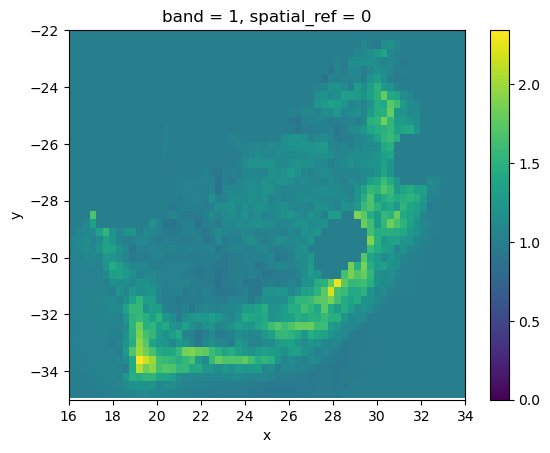

In [7]:
if apply_ws_correction:
    gwa_data = rioxarray.open_rasterio("../../data/bundle/ZAF_wind-speed_100m.tif")
    ds=gwa_data.sel(band=1, x=slice(*cutout_era5.extent[[0,1]]), y=slice(*cutout_era5.extent[[3,2]]))
    ds=ds.where(ds!=-999)
    ds=atlite.gis.regrid(ds,cutout_era5.data.x, cutout_era5.data.y,resampling=rasterio.warp.Resampling.average)

    bias_correction = ds/cutout_era5.data.wnd100m.mean("time") 
    bias_correction=bias_correction.fillna(1)
    fig, ax = plt.subplots()
    bias_correction.plot(ax=ax)
    ax.set_xlim(16,34)
    ax.set_ylim(-35,-22)

    cutout_era5.data.wnd100m.values=(bias_correction*cutout_era5.data.wnd100m).transpose('time', 'y', 'x').values

In [8]:
for hub_height in range(60, 121, 5):
    cutout_era5.data[f"wnd{hub_height}m"] = atlite.wind.extrapolate_wind_speed(cutout_era5.data, hub_height, from_height=100)

In [9]:
era5_power = pd.DataFrame(0, index = cutout_era5.coords["time"].values, columns = reippp_data.index)
era5_pu = era5_power.copy()

for plant, row in reippp_data.iterrows():
    
    # search cutout.grid fo the closest cell to the plant
    point = Point(row["longitude"], row["latitude"])
    nearest_point = cutout_era5.grid.geometry.distance(point).idxmin()
    cell_name = cutout_era5.grid.loc[nearest_point].name
    close_hub_height = min(range(60, 121, 5), key=lambda x:abs(x-row["hub_height"]))
    
    avg_hub_wind_speed = cutout_era5.data[f"wnd{close_hub_height}m"].sel(y=row["latitude"], x=row["longitude"], method="nearest").mean("time").values
    turb_class=3
    if avg_hub_wind_speed>8.5:
        turb_class=1
    elif (avg_hub_wind_speed<7.5) & (avg_hub_wind_speed>6.5):
        turb_class=2

    turbine = turbine_class[turb_class]
    turbine["hub_height"] = hub_height

    era5_pu[plant] = pd.Series(
        cutout_era5.wind(
            turbine=turbine, 
            shapes=cutout_era5.grid.iloc[cell_name:cell_name+1], 
            smooth=False, 
            add_cutout_windspeed=True, 
            per_unit=True
        ).values[:,0],
        index = cutout_era5.coords["time"].values, 
    )

    instl_cap = pd.Series(row["capacity"], index = era5_pu.index)
    instl_cap[instl_cap.index < row["COD"]] = 0
    capacity= instl_cap
    if row["ignore"]:
        capacity = 0
    era5_power[plant] = era5_pu[plant] * capacity

# WASA

WASA
This code assumes that data points for each reippp site have been downloaded from the available WASA timeseries dataset

In [10]:
def wind_power_calc(data, power_curve, turbine_class):
    return np.interp(data, power_curve.index, power_curve[f"Class {turbine_class}"].values)

wasa_files = []
for root, dirs, files in os.walk("../../data/weather/WASA weather files"):
    wasa_files.extend(file for file in files if file.endswith(".csv") and file.startswith("lat"))

In [11]:
date_range = cutout_era5.coords["time"].values
wasa_power=pd.DataFrame(0,index=date_range, columns=reippp_data.index)
wasa_pu = wasa_power.copy()
for plant, row in reippp_data.iterrows():
        filename = find_closest_wasa_file((row["latitude"],row["longitude"]), wasa_files)
        wind_data = pd.read_csv(f"../../data/weather/WASA weather files/{filename}",index_col=0,skiprows=8,parse_dates=True).resample('H').mean()
        idx = wind_data.index.intersection(date_range)
        wind_data = wind_data.loc[idx]

        try:
            hub_height = row['hub_height']
        except:
            hub_height=100

        if int(hub_height) not in [60,100,120,160]:
            wind_speed = pd.concat([wind_data[['S60','S100','S120','S160']].interpolate(), pd.Series(index=wind_data.index,name='hub_height')],axis=1)
            wind_speed = wind_speed.rename(columns={'S60':60,'S100':100,'S120':120,'S160':160,'hub_height':hub_height})
            wind_speed.sort_index(axis=1,inplace=True)
            hub_wind_speed = wind_speed.interpolate("pchip", axis=1)[hub_height]
        else:
            hub_wind_speed = wind_data[f"S{int(hub_height)}"]
        
        avg_hub_wind_speed = hub_wind_speed.mean()
        
        turb_class=3
        if avg_hub_wind_speed>8.5:
            turb_class=1
        elif (avg_hub_wind_speed<7.5) & (avg_hub_wind_speed>6.5):
            turb_class=2 

        instl_cap = pd.Series(row["capacity"], index = wasa_power.index)
        instl_cap[instl_cap.index < row["COD"]] = 0

        wasa_pu.loc[wind_speed.index, plant] = pd.Series(wind_power_calc(hub_wind_speed, turbine_power_curves, turb_class), index= wind_speed.index)
        capacity = instl_cap
        if row["ignore"]:
            capacity = 0
        wasa_power.loc[wind_speed.index, plant] = wasa_pu.loc[wind_speed.index, plant] * capacity
        

In [12]:
# remove any 29 Feb on leap years
era5_power = era5_power[~((era5_power.index.month == 2) & (era5_power.index.day == 29))]
era5_pu = era5_pu[~((era5_pu.index.month == 2) & (era5_pu.index.day == 29))]
wasa_power = wasa_power[~((wasa_power.index.month == 2) & (wasa_power.index.day == 29))]
wasa_pu = wasa_pu[~((wasa_pu.index.month == 2) & (wasa_pu.index.day == 29))]

# CSIR - Fraunhofer SWA Study

In [13]:
# Only available for RSA as single region or as 27 Supply Regions
csir_fise = pd.read_excel("csir_fise_SWA_data.xlsx", sheet_name = "27-wind", index_col=0, parse_dates=True)
csir_fise = csir_fise.iloc[1:]
csir_fise.index = pd.DatetimeIndex(csir_fise.index)
csir_fise = csir_fise[~((csir_fise.index.month == 2) & (csir_fise.index.day == 29))]
csir_fise = csir_fise.loc["2012":"2014"]

In [14]:
points_gdf = [Point(lon, lat) for lon,lat in reippp_data[["longitude", "latitude"]].values]
points_gdf = gpd.GeoDataFrame(geometry=points_gdf, crs="EPSG:4326")
region_list = gpd.sjoin(points_gdf,gis_data["supply_regions"][27],how="left",op="within")["name"]
reippp_data["csir_region"] = region_list.values

# Only 2 year is available in CSIR-FISE data which gets repeated to fill up according to the REIPPPP data
csir_pu = pd.DataFrame(
    index = era5_pu.index,
    columns = reippp_data.index
)
for idx, row in reippp_data.iterrows():
    for y in range(2017, 2023, 2):
        csir_pu.loc[csir_pu.index.year.isin([y, y+1]), idx] = csir_fise[row["csir_region"]].values

# Save and Export

In [15]:
for module in ["era5", "wasa", "csir"]:

    timeseries = xr.DataArray(
        np.zeros((len(era5_pu), len(era5_pu.columns), 2)),
        coords = {"time": era5_pu.index, "plant": era5_pu.columns.values, "param":["power", "pu"]},
        dims = ["time", "plant", "param"]
    )
    if module == "era5":
        timeseries.loc[dict(plant=era5_pu.columns.values, param="pu")] = era5_pu.values
        timeseries.loc[dict(plant=era5_pu.columns.values, param="power")] = era5_power.values
    elif module == "csir":
        timeseries.loc[dict(plant=csir_pu.columns.values, param="pu")] = csir_pu.values    
    else:
        timeseries.loc[dict(plant=wasa_pu.columns.values, param="pu")] = wasa_pu.values
        timeseries.loc[dict(plant=wasa_pu.columns.values, param="power")] = wasa_power.values


    timeseries.to_netcdf(f"timeseries_data/fixed_wind_{module}.nc")